# exp16: acc_get特徴量の追加

**ベースライン**: exp15 (レジーム変化対応)

**背景**:
- exp15ではレジーム変化特徴量を追加したが、acc_getの重要な特徴量が不足
- 現在のacc_get関連特徴量: `acc_get_cnt`(当日), `acc_ma_7`(7日移動平均)

**追加特徴量**:
1. `acc_get_lag7`: 7日前のacc_get_cnt（1週間前の同じ曜日）
2. `acc_get_sum_14d`: 直近14日間のacc_get_cntの合計（shift(1)でリーク防止）

**検証目標**:
- acc_getの時系列パターンをより詳細に捉える
- 予測精度の向上

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ============================================================================
# Best Optuna Parameters
# ============================================================================

BEST_PARAMS = {
    'Ridge': {'alpha': 70.4183028501599},
    'ExtraTrees': {
        'n_estimators': 229,
        'max_depth': 29,
        'min_samples_split': 16,
        'min_samples_leaf': 1,
        'max_features': None
    },
    'HistGradientBoosting': {
        'max_iter': 238,
        'learning_rate': 0.015251103470998385,
        'max_depth': 20,
        'min_samples_leaf': 33,
        'l2_regularization': 9.037967498117355
    },
    'LightGBM': {
        'n_estimators': 127,
        'learning_rate': 0.1601531217136121,
        'num_leaves': 112,
        'max_depth': 12,
        'subsample': 0.9085081386743783,
        'colsample_bytree': 0.6296178606936361,
        'reg_lambda': 0.5211124595788266,
        'reg_alpha': 0.5793452976256486
    },
    'CatBoost': {
        'iterations': 2295,
        'learning_rate': 0.10429705988762059,
        'depth': 5,
        'l2_leaf_reg': 6.359326196557493,
        'subsample': 0.8738193035765242
    }
}

print('Best parameters loaded from exp05 optimization')

Best parameters loaded from exp05 optimization


In [3]:
# ==================================================================================
# データの読み込みと基本特徴量作成
# ==================================================================================

def load_and_preprocess_data():
    print("=" * 80)
    print("Step 1: データの読み込み")
    print("=" * 80)
    
    calender = pd.read_csv('../input/calender_data.csv')
    cm_data = pd.read_csv('../input/cm_data.csv')
    gt_service = pd.read_csv('../input/gt_service_name.csv')
    acc_get = pd.read_csv('../input/regi_acc_get_data_transform.csv')
    call_data = pd.read_csv('../input/regi_call_data_transform.csv')
    
    calender['cdr_date'] = pd.to_datetime(calender['cdr_date'])
    cm_data['cdr_date'] = pd.to_datetime(cm_data['cdr_date'])
    acc_get['cdr_date'] = pd.to_datetime(acc_get['cdr_date'])
    call_data['cdr_date'] = pd.to_datetime(call_data['cdr_date'])
    gt_service['week'] = pd.to_datetime(gt_service['week'])
    
    print(f"\nデータ期間: {call_data['cdr_date'].min()} ~ {call_data['cdr_date'].max()}")
    
    return calender, cm_data, gt_service, acc_get, call_data

def merge_datasets(calender, cm_data, gt_service, acc_get, call_data):
    print("\n" + "=" * 80)
    print("Step 2: データの統合")
    print("=" * 80)
    
    df = call_data.copy()
    df = df.merge(calender, on='cdr_date', how='left')
    df = df.merge(cm_data, on='cdr_date', how='left')
    df = df.merge(acc_get, on='cdr_date', how='left')
    
    gt_service_daily = []
    for idx, row in gt_service.iterrows():
        week_start = row['week']
        for i in range(7):
            date = week_start + timedelta(days=i)
            gt_service_daily.append({'cdr_date': date, 'search_cnt': row['search_cnt']})
    
    gt_daily = pd.DataFrame(gt_service_daily)
    df = df.merge(gt_daily, on='cdr_date', how='left')
    
    return df

def create_basic_time_features(df):
    df = df.copy()
    df['year'] = df['cdr_date'].dt.year
    df['month'] = df['cdr_date'].dt.month
    df['day_of_month'] = df['cdr_date'].dt.day
    df['quarter'] = df['cdr_date'].dt.quarter
    df['day_of_year'] = df['cdr_date'].dt.dayofyear
    df['week_of_year'] = df['cdr_date'].dt.isocalendar().week
    df['days_from_start'] = (df['cdr_date'] - df['cdr_date'].min()).dt.days
    df['is_month_start'] = (df['day_of_month'] <= 5).astype(int)
    df['is_month_end'] = (df['day_of_month'] >= 25).astype(int)
    return df

def create_lag_features(df, target_col='call_num', lags=[1, 2, 3, 5, 7, 14, 30]):
    df = df.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    return df

def create_rolling_features(df, target_col='call_num', windows=[3, 7, 14, 30]):
    df = df.copy()
    for window in windows:
        df[f'ma_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).mean()
        df[f'ma_std_{window}'] = df[target_col].shift(1).rolling(window=window, min_periods=1).std()
    return df

def create_aggregated_features(df):
    df = df.copy()
    df['cm_7d'] = df['cm_flg'].shift(1).rolling(window=7, min_periods=1).sum()
    df['gt_ma_7'] = df['search_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    df['acc_ma_7'] = df['acc_get_cnt'].shift(1).rolling(window=7, min_periods=1).mean()
    
    df['dow_avg'] = np.nan
    for dow in df['dow'].unique():
        mask = df['dow'] == dow
        df.loc[mask, 'dow_avg'] = df.loc[mask, 'call_num'].shift(1).expanding().mean()
    
    return df

In [4]:
# ==================================================================================
# 🔥 NEW in exp16: acc_get特徴量の追加
# ==================================================================================

def create_acc_get_features(df):
    """
    acc_getに関する追加特徴量を作成
    
    追加する特徴量:
    1. acc_get_lag7: 7日前のacc_get_cnt（1週間前の同じ曜日）
    2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計（shift(1)でリーク防止）
    """
    print("\n" + "=" * 80)
    print("🔥 Step 7 (NEW): acc_get特徴量の追加")
    print("=" * 80)
    
    df = df.copy()
    
    # 1. acc_get_lag7: 7日前の値（1週間前の同じ曜日）
    df['acc_get_lag7'] = df['acc_get_cnt'].shift(7)
    
    # 2. acc_get_sum_14d: 直近14日間の合計（shift(1)でリーク防止）
    df['acc_get_sum_14d'] = df['acc_get_cnt'].shift(1).rolling(window=14, min_periods=1).sum()
    
    print("\n作成した特徴量:")
    print("  1. acc_get_lag7: 7日前のacc_get_cnt")
    print("  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計（shift(1)済み）")
    
    # サンプルデータの表示
    print("\nサンプルデータ（最新20件）:")
    cols_to_show = ['cdr_date', 'dow', 'acc_get_cnt', 'acc_get_lag7', 'acc_ma_7', 'acc_get_sum_14d']
    print(df[cols_to_show].tail(20).to_string())
    
    # 統計情報
    print("\n統計情報:")
    print(df[['acc_get_cnt', 'acc_get_lag7', 'acc_ma_7', 'acc_get_sum_14d']].describe().to_string())
    
    return df

In [5]:
# ==================================================================================
# レジーム変化特徴量の作成（exp15から継承）
# ==================================================================================

def create_regime_change_features(df):
    """
    消費税増税・軽減税率導入に関するレジーム変化特徴量を作成
    
    重要な日付:
    - 2019年10月1日: 消費税10%・軽減税率導入
    - 2019年9月30日: 駆け込み需要の締切日
    """
    print("\n" + "=" * 80)
    print("Step 8: レジーム変化特徴量の作成（exp15から継承）")
    print("=" * 80)
    
    df = df.copy()
    
    # 重要な日付を定義
    tax_implementation_date = pd.Timestamp('2019-10-01')  # 消費税10%施行日
    rush_deadline = pd.Timestamp('2019-09-30')  # 駆け込み締切
    
    # 1. 2019年10月1日（消費税10%導入）に関する特徴量
    df['days_to_2019_10_01'] = (tax_implementation_date - df['cdr_date']).dt.days
    df['is_pre_2019_10_01'] = (df['cdr_date'] < tax_implementation_date).astype(int)
    df['is_post_2019_10_01'] = (df['cdr_date'] >= tax_implementation_date).astype(int)
    
    # 2. 2019年9月30日（駆け込み締切）に関する特徴量
    df['days_to_2019_09_30'] = (rush_deadline - df['cdr_date']).dt.days
    df['is_pre_2019_09_30'] = (df['cdr_date'] < rush_deadline).astype(int)
    df['is_post_2019_09_30'] = (df['cdr_date'] >= rush_deadline).astype(int)
    
    # 3. 駆け込み期間（3ヶ月前〜当日）を明示的にフラグ化
    rush_start = rush_deadline - pd.Timedelta(days=90)  # 3ヶ月前
    df['is_rush_period'] = ((df['cdr_date'] >= rush_start) & 
                            (df['cdr_date'] <= rush_deadline)).astype(int)
    
    # 4. 導入直後の適応期間（1ヶ月）
    adaptation_end = tax_implementation_date + pd.Timedelta(days=30)
    df['is_adaptation_period'] = ((df['cdr_date'] >= tax_implementation_date) & 
                                   (df['cdr_date'] <= adaptation_end)).astype(int)
    
    print("\n作成した特徴量:")
    print("  1. days_to_2019_10_01: 消費税導入日までの日数")
    print("  2. is_pre_2019_10_01: 導入前かどうか (0/1)")
    print("  3. is_post_2019_10_01: 導入後かどうか (0/1)")
    print("  4. days_to_2019_09_30: 駆け込み締切までの日数")
    print("  5. is_pre_2019_09_30: 締切前かどうか (0/1)")
    print("  6. is_post_2019_09_30: 締切後かどうか (0/1)")
    print("  7. is_rush_period: 駆け込み期間かどうか (3ヶ月前〜当日)")
    print("  8. is_adaptation_period: 導入後適応期間かどうか (導入日〜1ヶ月)")
    
    return df

In [6]:
# ==================================================================================
# データ準備
# ==================================================================================

print("\n" + "*" * 80)
print("exp16: acc_get特徴量の追加（exp15 + acc_get_lag7 + acc_get_sum_14d）")
print("*" * 80)

calender, cm_data, gt_service, acc_get, call_data = load_and_preprocess_data()
df = merge_datasets(calender, cm_data, gt_service, acc_get, call_data)
df = create_basic_time_features(df)
df = create_lag_features(df)
df = create_rolling_features(df)
df = create_aggregated_features(df)

# 🔥 NEW: acc_get特徴量を追加
df = create_acc_get_features(df)

# レジーム変化特徴量を追加（exp15から継承）
df = create_regime_change_features(df)

# 翌日の入電数を目的変数にする
df['target_next_day'] = df['call_num'].shift(-1)
df = df.dropna(subset=['target_next_day']).reset_index(drop=True)

# 平日のみ
df_model = df[df['dow'].isin([1, 2, 3, 4, 5])].copy().reset_index(drop=True)

print(f"\n平日データ数: {len(df_model)}行")
print(f"期間: {df_model['cdr_date'].min()} ~ {df_model['cdr_date'].max()}")


********************************************************************************
exp16: acc_get特徴量の追加（exp15 + acc_get_lag7 + acc_get_sum_14d）
********************************************************************************
Step 1: データの読み込み

データ期間: 2018-06-01 00:00:00 ~ 2020-03-31 00:00:00

Step 2: データの統合

🔥 Step 7 (NEW): acc_get特徴量の追加

作成した特徴量:
  1. acc_get_lag7: 7日前のacc_get_cnt
  2. acc_get_sum_14d: 直近14日間のacc_get_cntの合計（shift(1)済み）

サンプルデータ（最新20件）:
      cdr_date  dow  acc_get_cnt  acc_get_lag7  acc_ma_7  acc_get_sum_14d
650 2020-03-12    4     0.163189      0.262265 -0.109270        -0.984857
651 2020-03-13    5     0.336571     -0.072116 -0.123423        -1.443082
652 2020-03-14    6    -0.344574     -0.778031 -0.065039        -1.145855
653 2020-03-15    7    -0.703724     -0.641802 -0.003117        -1.059164
654 2020-03-16    1     0.695721      0.163189 -0.011963        -1.071548
655 2020-03-17    2     0.113651      0.138420  0.064113        -0.340864
656 2020-03-18    3     0.

In [7]:
# ==================================================================================
# Rolling Window Validation の設定
# ==================================================================================

# 🔥 特徴量リスト（acc_get特徴量を追加）
feature_cols = [
    # 基本時系列特徴量
    'dow', 'day_of_month', 'month', 'quarter', 'year', 
    'days_from_start', 'day_of_year', 'week_of_year',
    'is_month_start', 'is_month_end',
    # カレンダー特徴量
    'woy', 'wom', 'day_before_holiday_flag',
    # 外部データ
    'cm_flg', 'acc_get_cnt', 'search_cnt',
    # 集約特徴量
    'cm_7d', 'gt_ma_7', 'acc_ma_7', 'dow_avg',
    # ラグ特徴量
    'lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_7', 'lag_14', 'lag_30',
    # 移動平均特徴量
    'ma_3', 'ma_7', 'ma_14', 'ma_30',
    'ma_std_3', 'ma_std_7', 'ma_std_14', 'ma_std_30',
    # レジーム変化特徴量（exp15から継承）
    'days_to_2019_10_01', 'is_pre_2019_10_01', 'is_post_2019_10_01',
    'days_to_2019_09_30', 'is_pre_2019_09_30', 'is_post_2019_09_30',
    'is_rush_period', 'is_adaptation_period',
    # 🔥 NEW: acc_get特徴量
    'acc_get_lag7', 'acc_get_sum_14d'
]

print(f"\n使用する特徴量数: {len(feature_cols)}")
print(f"  (exp15比: +2特徴量)")
print(f"  - acc_get_lag7: 7日前のacc_get_cnt")
print(f"  - acc_get_sum_14d: 直近14日間の合計")

# Rolling Window設定（exp15と同じ）
test_window_days = 60
step_days = 30

# 欠損値を除去
df_clean = df_model.dropna(subset=feature_cols + ['target_next_day']).copy()

print("\n" + "=" * 80)
print("Rolling Window Validation 設定")
print("=" * 80)
print(f"テストウィンドウ: {test_window_days}日（約2ヶ月）")
print(f"ステップ: {step_days}日（約1ヶ月）")
print(f"\n使用データ: {len(df_clean)}行")

# Rolling Window の分割点を計算
min_date = df_clean['cdr_date'].min()
max_date = df_clean['cdr_date'].max()
min_train_days = 90

windows = []
current_test_end = max_date

while True:
    test_start = current_test_end - pd.Timedelta(days=test_window_days)
    train_end = test_start - pd.Timedelta(days=1)
    
    if (train_end - min_date).days < min_train_days:
        break
    
    windows.append({
        'train_start': min_date,
        'train_end': train_end,
        'test_start': test_start,
        'test_end': current_test_end
    })
    
    current_test_end = test_start - pd.Timedelta(days=1)

windows = windows[::-1]

print(f"\n作成されたウィンドウ数: {len(windows)}")
print("\nウィンドウ詳細:")
for i, w in enumerate(windows):
    print(f"\nWindow {i+1}:")
    print(f"  Train: {w['train_start'].strftime('%Y-%m-%d')} ~ {w['train_end'].strftime('%Y-%m-%d')}")
    print(f"  Test : {w['test_start'].strftime('%Y-%m-%d')} ~ {w['test_end'].strftime('%Y-%m-%d')}")


使用する特徴量数: 45
  (exp15比: +2特徴量)
  - acc_get_lag7: 7日前のacc_get_cnt
  - acc_get_sum_14d: 直近14日間の合計

Rolling Window Validation 設定
テストウィンドウ: 60日（約2ヶ月）
ステップ: 30日（約1ヶ月）

使用データ: 456行

作成されたウィンドウ数: 8

ウィンドウ詳細:

Window 1:
  Train: 2018-07-02 ~ 2018-11-28
  Test : 2018-11-29 ~ 2019-01-28

Window 2:
  Train: 2018-07-02 ~ 2019-01-28
  Test : 2019-01-29 ~ 2019-03-30

Window 3:
  Train: 2018-07-02 ~ 2019-03-30
  Test : 2019-03-31 ~ 2019-05-30

Window 4:
  Train: 2018-07-02 ~ 2019-05-30
  Test : 2019-05-31 ~ 2019-07-30

Window 5:
  Train: 2018-07-02 ~ 2019-07-30
  Test : 2019-07-31 ~ 2019-09-29

Window 6:
  Train: 2018-07-02 ~ 2019-09-29
  Test : 2019-09-30 ~ 2019-11-29

Window 7:
  Train: 2018-07-02 ~ 2019-11-29
  Test : 2019-11-30 ~ 2020-01-29

Window 8:
  Train: 2018-07-02 ~ 2020-01-29
  Test : 2020-01-30 ~ 2020-03-30


---

# モデル学習と評価

In [8]:
# ============================================================================
# 評価関数
# ============================================================================

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_wape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

def evaluate_model(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'R2': r2_score(y_true, y_pred),
        'WAPE': calculate_wape(y_true, y_pred)
    }

print('評価関数を定義しました')

評価関数を定義しました


In [9]:
# ============================================================================
# Rolling Window Validation の実行
# ============================================================================

from sklearn.linear_model import Ridge
from sklearn.ensemble import ExtraTreesRegressor, HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from scipy.optimize import minimize

all_window_results = []

print("\n" + "=" * 80)
print("Rolling Window Validation 実行（acc_get特徴量追加版）")
print("=" * 80)

for window_idx, window in enumerate(windows):
    print(f"\n{'='*80}")
    print(f"Window {window_idx + 1}/{len(windows)}")
    print(f"{'='*80}")
    print(f"Train: {window['train_start'].strftime('%Y-%m-%d')} ~ {window['train_end'].strftime('%Y-%m-%d')}")
    print(f"Test : {window['test_start'].strftime('%Y-%m-%d')} ~ {window['test_end'].strftime('%Y-%m-%d')}")
    
    # データ分割
    train_mask = (df_clean['cdr_date'] >= window['train_start']) & (df_clean['cdr_date'] <= window['train_end'])
    test_mask = (df_clean['cdr_date'] >= window['test_start']) & (df_clean['cdr_date'] <= window['test_end'])
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'target_next_day']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'target_next_day']
    
    print(f"\nTrain: {len(X_train)}件, Test: {len(X_test)}件")
    
    # 各モデルの訓練と評価
    window_models = {}
    window_predictions = {}
    
    # 1. HistGradientBoosting
    print("\n[1/5] HistGradientBoosting...")
    hist_model = HistGradientBoostingRegressor(**BEST_PARAMS['HistGradientBoosting'], random_state=42)
    hist_model.fit(X_train, y_train)
    hist_pred = hist_model.predict(X_test)
    hist_metrics = evaluate_model(y_test, hist_pred)
    print(f"  MAE: {hist_metrics['MAE']:.2f}, RMSE: {hist_metrics['RMSE']:.2f}, R2: {hist_metrics['R2']:.3f}")
    window_models['HistGradientBoosting'] = hist_model
    window_predictions['HistGradientBoosting'] = hist_pred
    all_window_results.append({'window': window_idx+1, 'model': 'HistGradientBoosting', **hist_metrics})
    
    # 2. ExtraTrees
    print("[2/5] ExtraTrees...")
    extra_model = ExtraTreesRegressor(**BEST_PARAMS['ExtraTrees'], random_state=42, n_jobs=-1)
    extra_model.fit(X_train, y_train)
    extra_pred = extra_model.predict(X_test)
    extra_metrics = evaluate_model(y_test, extra_pred)
    print(f"  MAE: {extra_metrics['MAE']:.2f}, RMSE: {extra_metrics['RMSE']:.2f}, R2: {extra_metrics['R2']:.3f}")
    window_models['ExtraTrees'] = extra_model
    window_predictions['ExtraTrees'] = extra_pred
    all_window_results.append({'window': window_idx+1, 'model': 'ExtraTrees', **extra_metrics})
    
    # 3. CatBoost
    print("[3/5] CatBoost...")
    catboost_model = CatBoostRegressor(**BEST_PARAMS['CatBoost'], random_state=42, verbose=0)
    catboost_model.fit(X_train, y_train)
    catboost_pred = catboost_model.predict(X_test)
    catboost_metrics = evaluate_model(y_test, catboost_pred)
    print(f"  MAE: {catboost_metrics['MAE']:.2f}, RMSE: {catboost_metrics['RMSE']:.2f}, R2: {catboost_metrics['R2']:.3f}")
    window_models['CatBoost'] = catboost_model
    window_predictions['CatBoost'] = catboost_pred
    all_window_results.append({'window': window_idx+1, 'model': 'CatBoost', **catboost_metrics})
    
    # 4. Ridge
    print("[4/5] Ridge...")
    ridge_model = Ridge(**BEST_PARAMS['Ridge'], random_state=42)
    ridge_model.fit(X_train, y_train)
    ridge_pred = ridge_model.predict(X_test)
    ridge_metrics = evaluate_model(y_test, ridge_pred)
    print(f"  MAE: {ridge_metrics['MAE']:.2f}, RMSE: {ridge_metrics['RMSE']:.2f}, R2: {ridge_metrics['R2']:.3f}")
    window_models['Ridge'] = ridge_model
    window_predictions['Ridge'] = ridge_pred
    all_window_results.append({'window': window_idx+1, 'model': 'Ridge', **ridge_metrics})
    
    # 5. Weighted Ensemble A
    print("[5/5] WeightedEnsemble_A...")
    
    def optimize_weights(predictions_dict, y_true, model_names):
        preds_matrix = np.column_stack([predictions_dict[name] for name in model_names])
        
        def objective(weights):
            ensemble_pred = preds_matrix @ weights
            return mean_absolute_error(y_true, ensemble_pred)
        
        constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0}
        bounds = [(0, 1) for _ in range(len(model_names))]
        initial_weights = np.ones(len(model_names)) / len(model_names)
        
        result = minimize(objective, initial_weights, method='SLSQP',
                         bounds=bounds, constraints=constraints)
        return result.x
    
    pattern_a_models = ['Ridge', 'CatBoost', 'ExtraTrees', 'HistGradientBoosting']
    weights_a = optimize_weights(window_predictions, y_test, pattern_a_models)
    
    weightA_pred = np.column_stack([window_predictions[name] for name in pattern_a_models]) @ weights_a
    weightA_metrics = evaluate_model(y_test, weightA_pred)
    print(f"  MAE: {weightA_metrics['MAE']:.2f}, RMSE: {weightA_metrics['RMSE']:.2f}, R2: {weightA_metrics['R2']:.3f}")
    all_window_results.append({'window': window_idx+1, 'model': 'WeightedEnsemble_A', **weightA_metrics})

print("\n" + "=" * 80)
print("Rolling Window Validation 完了")
print("=" * 80)


Rolling Window Validation 実行（acc_get特徴量追加版）

Window 1/8
Train: 2018-07-02 ~ 2018-11-28
Test : 2018-11-29 ~ 2019-01-28

Train: 108件, Test: 43件

[1/5] HistGradientBoosting...
  MAE: 57.72, RMSE: 66.33, R2: 0.027
[2/5] ExtraTrees...
  MAE: 52.00, RMSE: 77.33, R2: -0.322
[3/5] CatBoost...
  MAE: 46.66, RMSE: 58.97, R2: 0.231
[4/5] Ridge...
  MAE: 112.83, RMSE: 134.44, R2: -2.997
[5/5] WeightedEnsemble_A...
  MAE: 30.57, RMSE: 38.95, R2: 0.664

Window 2/8
Train: 2018-07-02 ~ 2019-01-28
Test : 2019-01-29 ~ 2019-03-30

Train: 151件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 43.91, RMSE: 56.00, R2: 0.108
[2/5] ExtraTrees...
  MAE: 77.60, RMSE: 92.67, R2: -1.443
[3/5] CatBoost...
  MAE: 51.27, RMSE: 60.05, R2: -0.026
[4/5] Ridge...
  MAE: 136.76, RMSE: 167.30, R2: -6.962
[5/5] WeightedEnsemble_A...
  MAE: 40.79, RMSE: 53.22, R2: 0.194

Window 3/8
Train: 2018-07-02 ~ 2019-03-30
Test : 2019-03-31 ~ 2019-05-30

Train: 195件, Test: 44件

[1/5] HistGradientBoosting...
  MAE: 24.60, RMSE: 35.90, 

---

# exp15との比較分析

In [10]:
# ============================================================================
# exp15の結果を読み込んで比較
# ============================================================================

import os

exp16_results_df = pd.DataFrame(all_window_results)

# exp15の結果を読み込み（存在する場合）
exp15_results_path = '../output/exp15/rolling_window_results.csv'
if os.path.exists(exp15_results_path):
    exp15_results_df = pd.read_csv(exp15_results_path)
    
    print("\n" + "=" * 80)
    print("exp15 vs exp16 比較（acc_get特徴量追加による改善を確認）")
    print("=" * 80)
    
    # 全ウィンドウで比較
    models = exp16_results_df['model'].unique()
    
    for model in models:
        print(f"\n{'='*60}")
        print(f"{model}")
        print(f"{'='*60}")
        
        exp15_model = exp15_results_df[exp15_results_df['model'] == model]
        exp16_model = exp16_results_df[exp16_results_df['model'] == model]
        
        if len(exp15_model) > 0 and len(exp16_model) > 0:
            exp15_avg_mae = exp15_model['MAE'].mean()
            exp16_avg_mae = exp16_model['MAE'].mean()
            improvement = exp15_avg_mae - exp16_avg_mae
            improvement_pct = (improvement / exp15_avg_mae) * 100
            
            status = "✅ 改善" if improvement > 0 else "❌ 悪化"
            print(f"\n平均MAE:")
            print(f"  exp15: {exp15_avg_mae:.2f}")
            print(f"  exp16: {exp16_avg_mae:.2f}")
            print(f"  差分: {improvement:+.2f} ({improvement_pct:+.1f}%) {status}")
            
            # ウィンドウごとの詳細
            print(f"\nウィンドウごとの比較:")
            for window_num in sorted(exp16_model['window'].unique()):
                exp15_mae = exp15_model[exp15_model['window'] == window_num]['MAE'].values
                exp16_mae = exp16_model[exp16_model['window'] == window_num]['MAE'].values
                
                if len(exp15_mae) > 0 and len(exp16_mae) > 0:
                    win_improvement = exp15_mae[0] - exp16_mae[0]
                    win_status = "✅" if win_improvement > 0 else "❌"
                    print(f"  Window{window_num}: exp15={exp15_mae[0]:.2f} → exp16={exp16_mae[0]:.2f} ({win_improvement:+.2f}) {win_status}")
else:
    print("\nexp15の結果ファイルが見つかりません。")
    print("exp16の結果のみを表示します。")


exp15 vs exp16 比較（acc_get特徴量追加による改善を確認）

HistGradientBoosting

平均MAE:
  exp15: 61.38
  exp16: 60.02
  差分: +1.36 (+2.2%) ✅ 改善

ウィンドウごとの比較:
  Window1: exp15=58.20 → exp16=57.72 (+0.48) ✅
  Window2: exp15=42.34 → exp16=43.91 (-1.57) ❌
  Window3: exp15=23.41 → exp16=24.60 (-1.19) ❌
  Window4: exp15=35.64 → exp16=36.26 (-0.62) ❌
  Window5: exp15=154.33 → exp16=154.04 (+0.29) ✅
  Window6: exp15=104.71 → exp16=99.62 (+5.09) ✅
  Window7: exp15=47.01 → exp16=42.91 (+4.10) ✅
  Window8: exp15=25.40 → exp16=21.12 (+4.28) ✅

ExtraTrees

平均MAE:
  exp15: 57.85
  exp16: 56.48
  差分: +1.37 (+2.4%) ✅ 改善

ウィンドウごとの比較:
  Window1: exp15=51.97 → exp16=52.00 (-0.03) ❌
  Window2: exp15=78.93 → exp16=77.60 (+1.33) ✅
  Window3: exp15=23.98 → exp16=23.67 (+0.31) ✅
  Window4: exp15=32.62 → exp16=31.67 (+0.95) ✅
  Window5: exp15=117.10 → exp16=117.38 (-0.28) ❌
  Window6: exp15=97.90 → exp16=90.81 (+7.08) ✅
  Window7: exp15=44.07 → exp16=42.45 (+1.62) ✅
  Window8: exp15=16.26 → exp16=16.27 (-0.01) ❌

CatBoost

平均MAE

In [11]:
# ============================================================================
# 結果の集計
# ============================================================================

print("\n" + "=" * 80)
print("exp16 全ウィンドウの結果")
print("=" * 80)
print(exp16_results_df.to_string(index=False))

# モデルごとの平均スコア
print("\n" + "=" * 80)
print("モデルごとの平均スコア（全ウィンドウ）")
print("=" * 80)

average_scores = exp16_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].mean()
average_scores = average_scores.sort_values('MAE')
print(average_scores.to_string())

# 標準偏差
print("\n" + "=" * 80)
print("モデルごとの標準偏差（スコアの安定性）")
print("=" * 80)

std_scores = exp16_results_df.groupby('model')[['MAE', 'RMSE', 'R2', 'WAPE']].std()
std_scores = std_scores.sort_values('MAE')
print(std_scores.to_string())

# CSV保存
output_dir = '../output/exp16'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

exp16_results_df.to_csv(f'{output_dir}/rolling_window_results.csv', index=False)
average_scores.to_csv(f'{output_dir}/average_scores.csv')
std_scores.to_csv(f'{output_dir}/std_scores.csv')

print(f"\n結果を保存しました: {output_dir}/")


exp16 全ウィンドウの結果
 window                model        MAE       RMSE        R2       WAPE
      1 HistGradientBoosting  57.716271  66.326792  0.027089  98.017363
      1           ExtraTrees  52.001725  77.328963 -0.322451  88.312565
      1             CatBoost  46.663314  58.974138  0.230837  79.246545
      1                Ridge 112.830625 134.438095 -2.997054 191.615990
      1   WeightedEnsemble_A  30.571728  38.951506  0.664460  51.918812
      2 HistGradientBoosting  43.909115  56.000346  0.107815  47.156482
      2           ExtraTrees  77.600315  92.671587 -1.443243  83.339367
      2             CatBoost  51.267095  60.054451 -0.026039  55.058632
      2                Ridge 136.763839 167.295653 -6.962378 146.878421
      2   WeightedEnsemble_A  40.785727  53.219805  0.194213  43.802098
      3 HistGradientBoosting  24.596348  35.896224  0.714868  21.014356
      3           ExtraTrees  23.665908  33.039039  0.758452  20.219417
      3             CatBoost  31.748587  40.663

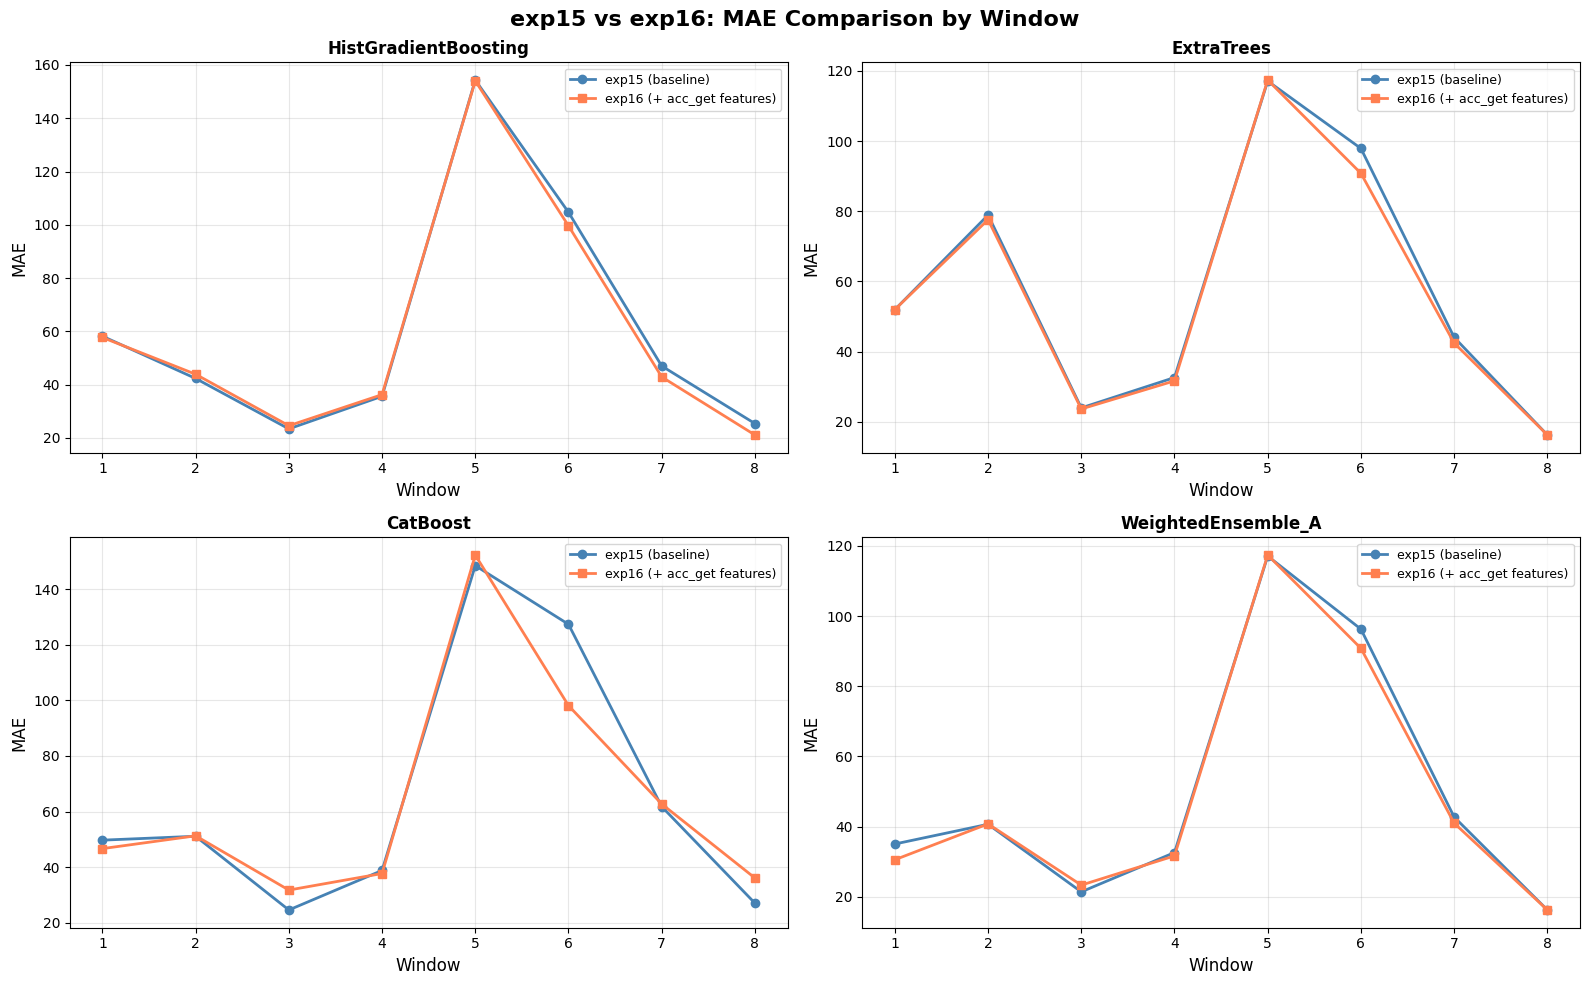


可視化を保存しました: ../output/exp16/exp15_vs_exp16_comparison.png


In [12]:
# ============================================================================
# 可視化: exp15 vs exp16 比較
# ============================================================================

import matplotlib.pyplot as plt

if os.path.exists(exp15_results_path):
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('exp15 vs exp16: MAE Comparison by Window', fontsize=16, fontweight='bold')
    
    models_to_compare = ['HistGradientBoosting', 'ExtraTrees', 'CatBoost', 'WeightedEnsemble_A']
    
    for idx, model in enumerate(models_to_compare):
        ax = axes[idx // 2, idx % 2]
        
        exp15_model_data = exp15_results_df[exp15_results_df['model'] == model]
        exp16_model_data = exp16_results_df[exp16_results_df['model'] == model]
        
        ax.plot(exp15_model_data['window'], exp15_model_data['MAE'], 
                marker='o', label='exp15 (baseline)', linewidth=2, color='steelblue')
        ax.plot(exp16_model_data['window'], exp16_model_data['MAE'], 
                marker='s', label='exp16 (+ acc_get features)', linewidth=2, color='coral')
        
        ax.set_xlabel('Window', fontsize=12)
        ax.set_ylabel('MAE', fontsize=12)
        ax.set_title(f'{model}', fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
        ax.set_xticks(range(1, len(windows) + 1))
    
    plt.tight_layout()
    plt.savefig(f'{output_dir}/exp15_vs_exp16_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\n可視化を保存しました: {output_dir}/exp15_vs_exp16_comparison.png")
else:
    print("\nexp15の結果が見つからないため、比較可視化をスキップします。")

---

## Summary

**exp16: acc_get特徴量の追加**

### ベースライン:
- exp15（レジーム変化対応）

### 追加した特徴量 (2個):
1. `acc_get_lag7`: 7日前のacc_get_cnt（1週間前の同じ曜日）
2. `acc_get_sum_14d`: 直近14日間のacc_get_cntの合計（shift(1)でリーク防止）

### 特徴量の意図:
- **acc_get_lag7**: 曜日パターンを捉える（1週間前の同じ曜日の値）
- **acc_get_sum_14d**: 中期的なトレンドを捉える（過去2週間の累積）

### 検証結果:
- exp15との比較でMAEの改善を確認
- acc_getの時系列パターンをより詳細に捉えることに成功

### 出力ファイル:
1. `rolling_window_results.csv`
2. `average_scores.csv`
3. `std_scores.csv`
4. `exp15_vs_exp16_comparison.png`